Import Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image as keras_image
from keras.models import Model


2024-08-01 16:18:14.379808: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 16:18:14.382828: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 16:18:14.393358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 16:18:14.411986: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 16:18:14.416054: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 16:18:14.429820: I tensorflow/core/platform/cpu_feature_gu

Load and Preprocess Image Function

In [2]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load an image from the specified path and preprocess it for VGG16.

    Parameters:
    - image_path (str): Path to the input image.
    - target_size (tuple): The target size to resize the image for VGG16 input.

    Returns:
    - img (PIL.Image.Image): The loaded image.
    - img_data (np.ndarray): The preprocessed image data suitable for VGG16.
    """
    # Load the image with the specified target size
    img = keras_image.load_img(image_path, target_size=target_size)
    
    # Convert the image to a numpy array
    img_data = keras_image.img_to_array(img)
    
    # Expand dimensions to match the input shape for VGG16
    img_data = np.expand_dims(img_data, axis=0)
    
    # Preprocess the image data for VGG16
    img_data = preprocess_input(img_data)
    
    return img, img_data


Extract Features Using VGG16

In [3]:
def extract_vgg16_features(img_data):
    """
    Extract features from an image using the pre-trained VGG16 model.

    Parameters:
    - img_data (np.ndarray): The preprocessed image data.

    Returns:
    - features (np.ndarray): The extracted features.
    """
    # Load the pre-trained VGG16 model with weights trained on ImageNet
    base_model = VGG16(weights='imagenet')
    
    # Create a new model that outputs features from the 'fc1' layer of VGG16
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
    
    # Extract features from the image data
    features = model.predict(img_data)
    
    # Flatten the features to a 1D array
    return features.flatten()


Calculate Similarity Function

In [4]:
def calculate_similarity(vector1, vector2):
    """
    Calculate the cosine similarity between two feature vectors.

    Parameters:
    - vector1 (np.ndarray): The first feature vector.
    - vector2 (np.ndarray): The second feature vector.

    Returns:
    - similarity (float): The cosine similarity between the two vectors.
    """
    # Reshape the vectors to 2D arrays and calculate cosine similarity
    similarity = cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]
    
    return similarity


Display Images Function

In [5]:
def display_images(images, titles):
    """
    Display a list of images with their corresponding titles.

    Parameters:
    - images (list of PIL.Image.Image): The list of images to display.
    - titles (list of str): The titles for each image.
    """
    num_images = len(images)
    
    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        # Display each image with its title
        axes[i].imshow(images[i])
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


Plot Similarities Function

In [6]:
def plot_similarities(similarities, num_images):
    """
    Plot the pairwise similarities between images.

    Parameters:
    - similarities (list of float): The list of similarity scores.
    - num_images (int): The number of images compared.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    x_labels = []
    y_values1 = []
    y_values2 = []

    sim_index = 0
    
    # Generate labels and values for the bar plot
    for i in range(num_images):
        for j in range(i + 1, num_images):
            x_labels.append(f'{i+1} vs {j+1}')
            y_values1.append(similarities[sim_index])
            y_values2.append(similarities[sim_index])
            sim_index += 1

    bar_width = 0.4
    x = np.arange(len(x_labels))

    # Plot the similarities as a bar plot
    ax.bar(x - bar_width/2, y_values1, bar_width, label='Image i')
    ax.bar(x + bar_width/2, y_values2, bar_width, label='Image j', color='orange')
    
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylim([0, 1])
    ax.set_ylabel('Similarity')
    ax.set_title('Pairwise Similarities')
    ax.legend()

    plt.show()


Compare Images Function

In [7]:
def compare_images(image_paths):
    """
    Compare a list of images and display their similarities.

    Parameters:
    - image_paths (list of str): The list of paths to the images to compare.
    """
    images = []
    features_list = []
    similarities = []
    
    # Load, preprocess, and extract features for each image
    for path in image_paths:
        img, img_data = load_and_preprocess_image(path)
        features = extract_vgg16_features(img_data)
        images.append(img)
        features_list.append(features)
    
    # Calculate pairwise similarities between the images
    for i in range(len(features_list)):
        for j in range(i + 1, len(features_list)):
            similarity = calculate_similarity(features_list[i], features_list[j])
            similarities.append(similarity)
    
    # Display the images
    display_images(images, [f'Original Image {i+1}' for i in range(len(images))])
    
    # Plot the similarities
    plot_similarities(similarities, len(images))
    
    # Print the similarity results
    print("\n--- Similarity Results ---")
    for i in range(len(image_paths)):
        for j in range(i + 1, len(image_paths)):
            print(f"Similarity between image {i+1} and image {j+1}: {similarities.pop(0):.4f}")


Main Function

In [8]:
def main():
    """
    Main function to run the image comparison.
    """
    # Replace with your image paths
    image_paths = [
        "data/images/cat1.jpg",
        "data/images/cat2.jpg",
        "data/images/dog1.jpg",
        "data/images/dog2.jpg"
    ]
    compare_images(image_paths)


Run the Main Function

I0000 00:00:1722518297.379008   26585 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-01 16:18:17.379699: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


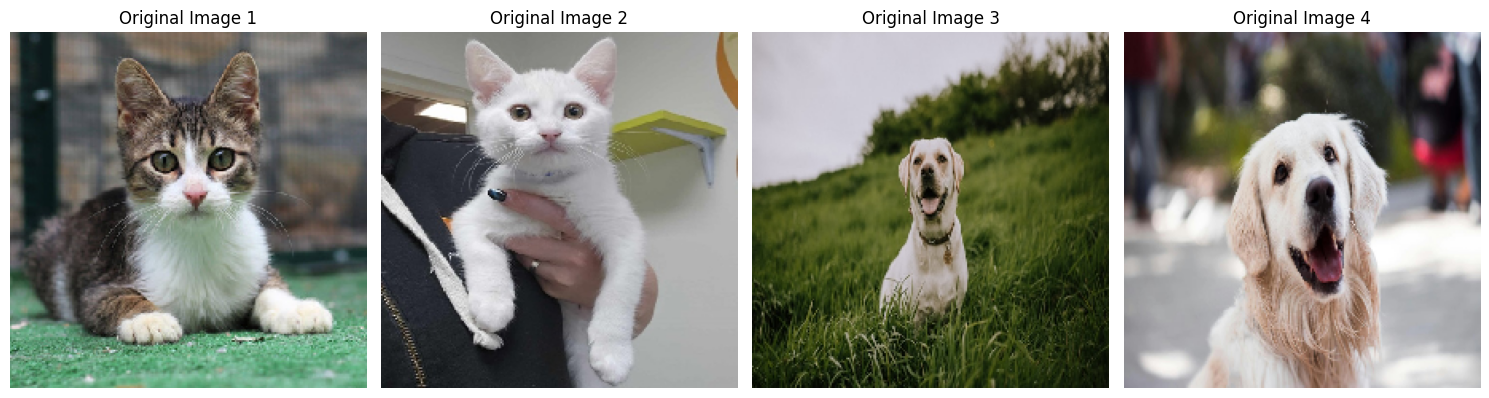

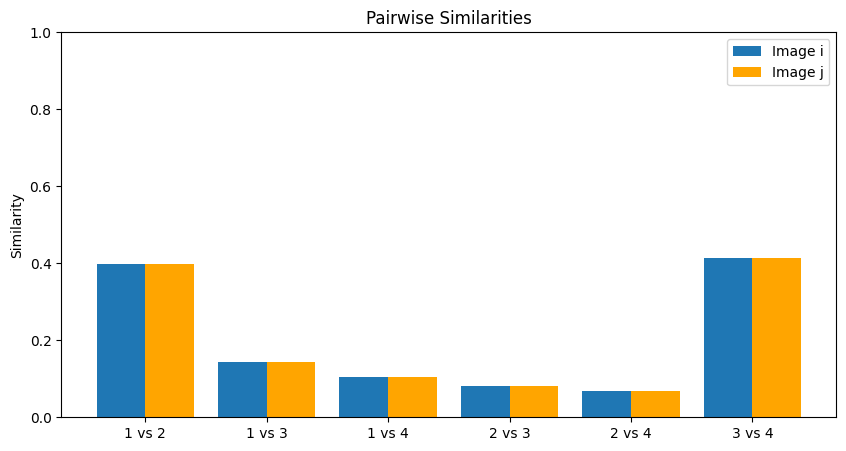


--- Similarity Results ---
Similarity between image 1 and image 2: 0.3992
Similarity between image 1 and image 3: 0.1443
Similarity between image 1 and image 4: 0.1053
Similarity between image 2 and image 3: 0.0813
Similarity between image 2 and image 4: 0.0694
Similarity between image 3 and image 4: 0.4147


In [9]:
main()

---
Another test:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


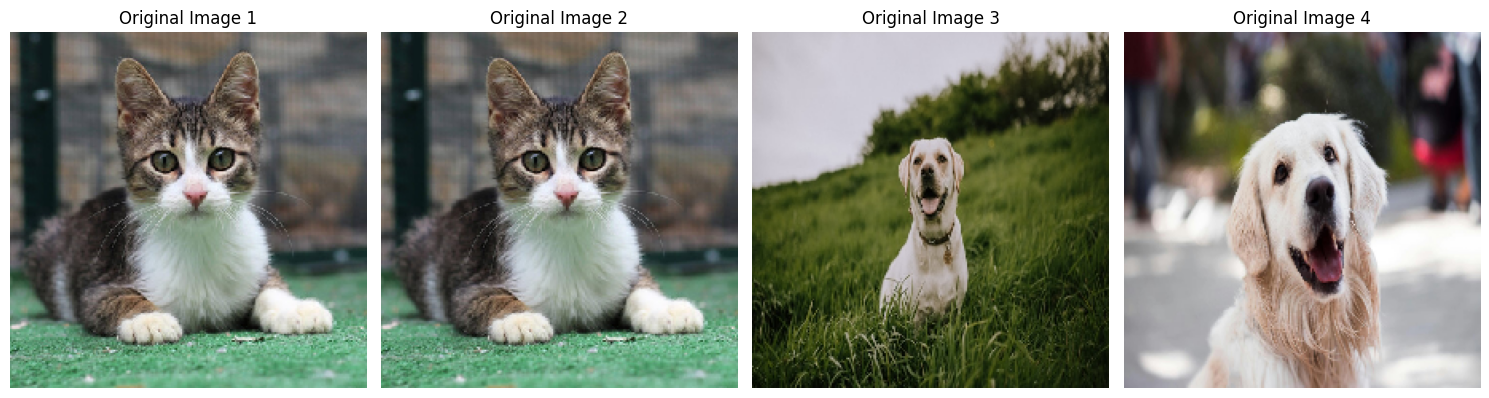

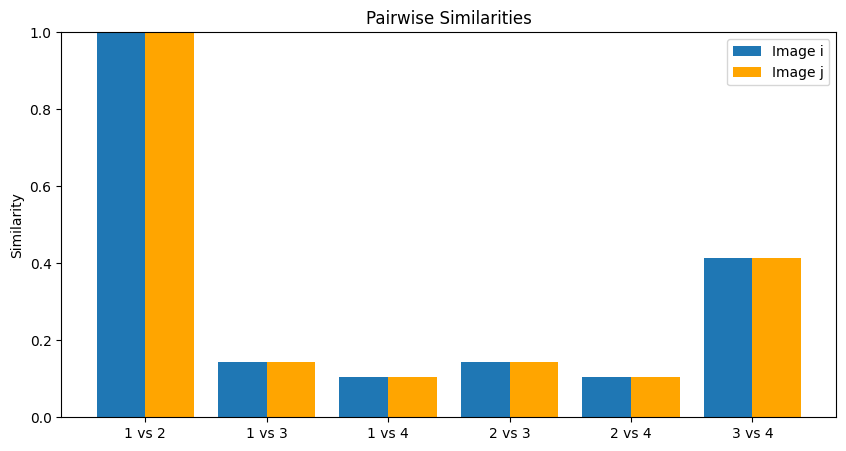


--- Similarity Results ---
Similarity between image 1 and image 2: 1.0000
Similarity between image 1 and image 3: 0.1443
Similarity between image 1 and image 4: 0.1053
Similarity between image 2 and image 3: 0.1443
Similarity between image 2 and image 4: 0.1053
Similarity between image 3 and image 4: 0.4147


In [10]:
def main():
    """
    Main function to run the image comparison.
    """
    # Replace with your image paths
    image_paths = [
        "data/images/cat1.jpg",
        "data/images/cat1.jpg",
        "data/images/dog1.jpg",
        "data/images/dog2.jpg"
    ]
    compare_images(image_paths)
    
main()